In [1]:
# 1. Import thư viện cần thiết

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('BTC-USD.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 11s 256ms/step - loss: 0.0591 - val_loss: 0.0064
Epoch 2/100
16/16 [==============================] - 4s 250ms/step - loss: 0.0084 - val_loss: 0.0024
Epoch 3/100
16/16 [==============================] - 3s 174ms/step - loss: 0.0037 - val_loss: 0.0046
Epoch 4/100
16/16 [==============================] - 3s 173ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 5/100
16/16 [==============================] - 3s 173ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 6/100
16/16 [==============================] - 4s 236ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 7/100
16/16 [==============================] - 3s 174ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 8/100
16/16 [==============================] - 3s 172ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 9/100
16/16 [==============================] - 3s 182ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 10/100
16/16 [==============================] - 3s 216ms/step - loss: 0.0024 - val_l

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 33ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)


In [12]:
y_train = y_train.reshape(y_train.shape[0],1)
ytest = ytest.reshape(ytest.shape[0],1)
yval = yval.reshape(yval.shape[0],1)

y_train=scaler.inverse_transform(y_train)
ytest=scaler.inverse_transform(ytest)
yval=scaler.inverse_transform(yval)

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
# valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
# test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
# print('Validation RMSE:', valid_rmse)
# print('Testing RMSE:', test_rmse)
print('Train Mean Squared Error:', math.sqrt(mean_squared_error(y_train[:,0], train_predict[:,0])))
print('Test Mean Squared Error:', math.sqrt(mean_squared_error(ytest[:,0], y_pred[:,0])))
print('Val Mean Squared Error:', math.sqrt(mean_squared_error(yval[:,0], y_pred_val[:,0])))
print('Train Score: %.2f RMSE' % (math.sqrt(mean_squared_error(y_train[:,0], train_predict[:,0]))))
print('Test Score: %.2f RMSE' % (math.sqrt(mean_squared_error(ytest[:,0], y_pred[:,0]))))
print('Val Score: %.2f RMSE' % (math.sqrt(mean_squared_error(yval[:,0], y_pred_val[:,0]))))
print('Train Mean Absolute Percentage Error:', mean_absolute_percentage_error(y_train[:,0], train_predict[:,0]))
print('Test Mean Absolute Percentage Error:', mean_absolute_percentage_error(ytest[:,0], y_pred[:,0]))
print('Val Mean Absolute Percentage Error:', mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0]))
print('Train Score: %.2f MAPE' % (mean_absolute_percentage_error(y_train[:,0], train_predict[:,0])))
print('Test Score: %.2f MAPE' % (mean_absolute_percentage_error(ytest[:,0], y_pred[:,0])))
print('Val Score: %.2f MAPE' % (mean_absolute_percentage_error(yval[:,0], y_pred_val[:,0])))

Train Mean Squared Error: 1397.3267182458062
Test Mean Squared Error: 1239.2498358159633
Val Mean Squared Error: 1142.1076838696831
Train Score: 1397.33 RMSE
Test Score: 1239.25 RMSE
Val Score: 1142.11 RMSE
Train Mean Absolute Percentage Error: 0.04115271308978227
Test Mean Absolute Percentage Error: 0.03641841042242732
Val Mean Absolute Percentage Error: 0.037184728378921166
Train Score: 0.04 MAPE
Test Score: 0.04 MAPE
Val Score: 0.04 MAPE


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[30:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=125
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.20329894 0.19975656 0.20330448 0.21458099 0.2114418  0.21333571
 0.21052394 0.21398754 0.21156169 0.21334886 0.20958718 0.21559253
 0.21402909 0.21396008 0.21357778 0.21517118 0.22413027 0.22466531
 0.21764016 0.20646032 0.20876067 0.20818225 0.20322184 0.21049384
 0.20911043 0.20931001 0.20878967 0.2095814  0.20949148 0.21070422
 0.20754637 0.20498118 0.20638017 0.20576061 0.20490207 0.20611116
 0.20709906 0.20696483 0.20982268 0.20940967 0.21120548 0.21125393
 0.21337443 0.21501716 0.21890915 0.22652367 0.24109013 0.25729753
 0.27392163 0.27243334 0.2769346  0.27680816 0.26944089 0.2756436
 0.30041881 0.30199395 0.30110239 0.30443766 0.29979413 0.30729625
 0.30597031 0.30668642 0.30594401 0.31753053 0.30296818 0.30763012
 0.3167389  0.31281325 0.31246185 0.31063109 0.30476858 0.30172098
 0.30957827 0.30451507 0.28705511 0.28443921 0.28786293 0.28657455
 0.28688465 0.29331632 0.32584123 0.31517588 0.32985822 0.33103757
 0.32614981 0.3339654  0.32784398 0.32398673 0.3202

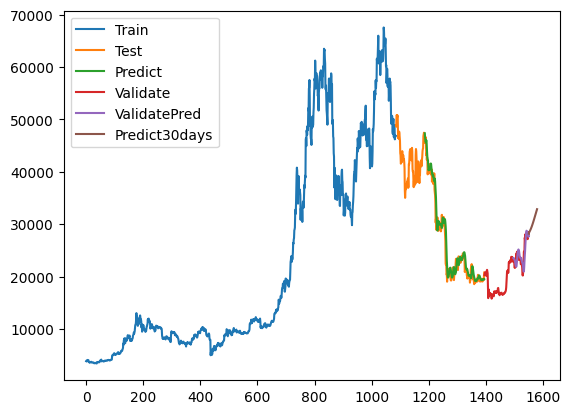

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()